### MongoDB Challenges

##### Setup

Make sure that mongodb is setup and the database server (`mongod`) is running.

We are going to work with reviews of Heavy Metal movies. Hellz Yeah.
Unzip and unpickle the following file:

[heavy_metal_parsed.pkl.zip](heavy_metal_parsed.pkl.zip)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import operator

In [1]:
import pickle
with open("heavy_metal_parsed.pkl", 'rb') as datafile:
    heavy_metal_reviews = pickle.load(datafile)

It's a list of dictionaries. One dictionary per review: perfect for a mongo document.
The key `raw` has the full text as a list of lines. For example, to see the first review, you can do:

In [2]:
first_review = heavy_metal_reviews[0]
for line in first_review['raw']:
    print(line)

200 MOTELS (1971)
DIRECTORS: Tony Palmer, Frank Zappa
CAST: Frank Zappa, Ringo Starr, Mark Volman, Howard Kaylan, Keith
Moon
METAL CRED
Frank Zappa
Nun Desecration
THE MEAT
Beyond his metal sainthood for
battling the censor-witches of the PMRC and getting named checked by Deep
Purple in “Smoke on the Water”, musical visionary Frank Zappa led many rock
fans to heavy metal.
And, from there, he led many metal
fans to the outer expanses of rock’s possibilities.
Zappa also opened countless banging
heads to the far reaches of jazz, classical, doo-wop, and any other art form
that could involve (brilliant) noise and (brilliantly dumb) dirty jokes.
200
Motels is Zappa’s first crack at major motion picture madness, and it
embodies the much forgotten cultural moment when acid rock tumbled forever into
the black pits of rising heavy metal.
Surrealistic sketches and
psychedelic set pieces about the insanity of a being on tour are interspersed
among performances in which the Mothers jam with London 

Let's see what other fields each document has:

In [3]:
print(list(first_review.keys()))

['raw', 'solid_metal_nuggets', 'head', 'metal_cred', 'the_meat', 'title', 'year', 'sections', 'direct', 'cast']


Basically, each section in the review is parsed into it's own key.

Ok, put these documents into a mongodb collection. For these challenges, do not use the `heavy_metal_reviews` list directly. Use mongo queries (you can use the mongo client directly or use pymongo from within python).

In [3]:
from pymongo import MongoClient

In [4]:
client = MongoClient()

In [5]:
db = client.db

In [6]:
reviews = db.reviews

```python
for review in heavy_metal_reviews:
    reviews.insert_one(review)
```

##### Challenge 1
Make a histogram of the years in the data. How many metal movies came
out over the years?

In [67]:
year_count = reviews.aggregate([
    {"$group": {
        "_id": "$year",
        "year_count": {"$sum": 1}
    }}
])

In [68]:
years = []
num_films_in_year = []
for doc in year_count:
    years.append(doc["_id"])
    num_films_in_year.append(doc["year_count"])

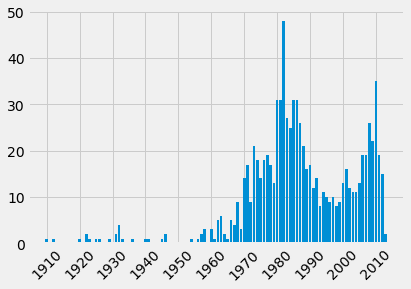

In [148]:
plt.bar(years, num_films_in_year);
plt.style.use('fivethirtyeight')
plt.xticks(np.arange(min(years), max(years)+7, 10),rotation=45)
plt.show();

##### Challenge 2
Find the cast member that appeared in most Heavy Metal movies. Is
there one that is shared by more than one of these movies? Or are they
all completely different actors for every movie?

In [19]:
most_movies = reviews.aggregate([
    #project
    #match where exists and not ''
    {'$unwind': '$cast'},
    {'$group' : {'_id': '$cast',
    'num_movies': {'$sum' : 1}}},
    {'$sort' : {'num_movies' : -1}}
])

In [11]:
fieldName = 'cast'

# Key: actor name; value: # appearances in cast
cast = {}
cursor = reviews.find()
for doc in cursor:
    if doc[fieldName]:
        for m in doc[fieldName]:
            if m != '':
                if m in cast:
                    cast[m] += 1
                else:
                    cast[m] = 1

sortedCast = sorted(cast.items(), key=operator.itemgetter(1), reverse=True)

print(sortedCast[:3])

[('Alice Cooper', 15), ('Christopher Lee', 14), ('Arnold Schwarzenegger', 10)]


##### Challenge 3
Find the most used words in Heavy Metal film titles. Is there a word
that appears in a lot of them? Is it "The"? If it is something like
"the", How can you get around that? Find one "meaningful" word that
appears the most (this means non-structural word, unlike "the" or "a"
or "in")

In [142]:
#what we will ignore when searching titles
ignore = ['the', 'an', 'and','a','to', 'of', 'by', u'\u201cThe', u'\u2013', 
          u'\u201980s', 'The', u'\u2022', 'in', u'\u201970s', ' ', 'on', 'from', 'at', 'for', 'with']


In [149]:
#project acts as a field filter. this will suppress _id and only pass the title
title_count = reviews.aggregate([
    {'$project': {'_id': 0, 'title': 1}}
])

In [150]:
#store counts
title_word_count = {}

#parse each title
for document in title_count:
    #split title into words
    for word in document['title'].split():
        
        word = word.lower()
        
        if word in ignore:
            continue
        if word in title_word_count:
            title_word_count[word] += 1
        else:
            title_word_count[word] = 1

In [151]:
listed_title_counts = sorted(title_word_count.items(), key= lambda x: x[1], reverse=True)

In [152]:
listed_title_counts[:5]

[('metal', 29), ('dead', 23), ('heavy', 18), ('rock', 17), ('blood', 14)]

##### Challenge 4
METAL CRED section lists themes included in these movies that makes
them more metal.
What were the top 5 metal cred keywords in the 70s? In 80s? In 90s, In
2000s?

In [177]:
def metal_cred(year):
    #return metal_cred and year for films within 10 year range
    pipeline = [
        {'$project': {'_id':0, 'metal_cred': 1, 'year': 1}},
        {'$match': {'year' :{'$gte': year}}},
        {'$match': {'year' :{'$lt': year+10}}}
    ]
    
    credibility = reviews.aggregate(pipeline)
    cred_words = {}
    
    for doc in credibility:
        for item in doc['metal_cred']:
            if item == 'METAL CRED':
                continue
            else:
                for word in item.split():

                    word = word.lower()

                    if word in ignore:
                        continue
                    if word in cred_words:
                        cred_words[word] += 1
                    else:
                        cred_words[word] = 1
    return sorted(cred_words.items(), key= lambda x: x[1], reverse=True)

In [181]:
metal_cred(1970)[:5]

[('satan', 21), ('black', 14), ('horror', 13), ('metal', 12), ('manson', 12)]

In [180]:
metal_cred(1980)[:5]

[('post-apocalypse', 31),
 ('horror', 30),
 ('metal', 28),
 ('sorcery', 28),
 ('sword', 26)]

In [182]:
metal_cred(1990)[:5]

[('soundtrack:', 37),
 ('metal', 17),
 ('black', 9),
 ('alice', 8),
 ('marilyn', 7)]

##### Challenge 5
Let's use the length of the METAL CRED section as a proxy score for
how metal a movie is. Let's call this the METAL SCORE. To each mongo
document, add the metal_score as a new field.

In [ ]:
#update_metalscore = reviews.update_many(
#     {},
#     {"$set": {"metal_score": len(reviews['metal_cred'])   }},
#     False, 
#     True)

In [17]:
cursor = reviews.find()
for doc in cursor:
    if doc['metal_cred']:
        doc['metal_score'] = len(doc['metal_cred'])

In [24]:
reviews.find()[27]['metal_score']

11

##### Challenge 6
Find the director that is MOST METAL per movie (director with the
highest average metal score).
Remember that some movies have multiple directors.

In [30]:
directors = {}

cursor = reviews.find()
for doc in cursor:
    if doc['direct']:
        for director in doc['direct']:
            if director != '':
                if director in directors:
                    directors[director].append(doc['metal_score'])
                else:
                    directors[director] = [doc['metal_score']]

In [38]:
mean_metal = sorted([(key, sum(values)/len(values)) for (key, values) in directors.items()],
                    key= lambda x: x[1],
                    reverse=True)

In [39]:
mean_metal[:3]

[('John Milius', 75.0), ('David Jacobson', 27.0), ('Robert Hendrickson', 18.0)]

##### Challenge 7
The majority of directors and actors will have worked on a single
movie. See if there are any directors that worked with an actor more
than once. If so, find the director-actor duo that have worked
together the most times.

In [51]:
dir_act_duo = {}
cursor = reviews.find()

for doc in cursor:
    if doc['cast'] and doc['direct']:
        for director in doc['direct']:
            for actor in doc['cast']:
                pair = (director, actor)
                if pair in dir_act_duo:
                    dir_act_duo[pair] += 1
                else:
                    dir_act_duo[pair] = 1

In [52]:
top_pairs = sorted([(key, value) for (key, value) in dir_act_duo.items()],
                    key= lambda x: x[1],
                    reverse=True)

In [53]:
top_pairs[:3]

[(('Peter Jackson', 'Christopher Lee'), 4),
 (('Dario Argento', 'Daria Nicolodi'), 4),
 (('Joe D’Amato', 'George Eastman'), 4)]

##### Challenge 8
Create an index on the 'director' field to make the queries involving
it faster.
[What is an index?](http://en.wikipedia.org/wiki/Database_index)

[Creating an index in mongo](http://docs.mongodb.org/manual/tutorial/create-an-index/)
[Creating an index in pymongo](http://api.mongodb.org/python/current/api/pymongo/collection.html?highlight=create_index#pymongo.collection.Collection.create_index)
[Single field index on mongo](http://docs.mongodb.org/manual/core/index-single/)
[Mongo documentation on indexes](http://docs.mongodb.org/manual/core/indexes/)

##### Challenge 9 (Optional challenge for early finishers)
For each decade, make a histogram of metal scores.
Also, calculate the average metal score for each decade. Which decade
was the most pure metal decade?

##### Note (rather than a challenge)
In the latest version of mongo, you can do a text query.
To do this, you need to create one (only one) text-based index.
Let's index the_meat field so we can make text search queries on it
(in pymongo):

db.reviews.create_index([("the_meat", pymongo.TEXT,)])

Now you can do text search. For example, let's search for the phrase
"hitting power chords" within "the_meat" fields of all our documents.

    db.reviews.find({"$text": {"$search": "hitting power
    chords"}}).count()

    206

It has found 206 reviews. I can print the titles of the first 10
reviews that were returned in this text search:

    ten_matches = r.find({"$text": {"$search": "hitting power chords"}}).limit(10)
    for match in ten_matches:
        print match["title"]


    DOMINATOR
    REPO: THE GENETIC OPERA
    GREMLINS 2: THE NEW BATCH
    VICE SQUAD
    THE JERKY BOYS: THE MOVIE
    THE SONG REMAINS THE SAME
    THE EXORCIST
    THE CROW
    CANNIBAL HOLOCAUST
    HOSTEL

Enjoy your text searches : ) These can be very useful in some apps.


### Twitter API Extension

Create a mongo collection of tweets about something (anything you
choose).

Each mongo document should contain the text, username, favorite count
and retweet count of the tweet.